In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import time

from isochrones import get_ichrone
from sbi import analysis
import corner
import pandas as pd
from sbi.utils import process_prior
from sbi import utils
from sbi.inference import SNPE as method

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Define simulator

In [2]:
tracks = get_ichrone('mist', tracks=True)

# def binary_color_mag_isochrones(m1, q, age, fe_h, log_dist):
#     # isochrones.py needs log10(Age [yr]). 
#     # Our age is in Gyr, so we take log10(age * 10^9) = log10(age) + 9
#     dist = np.float64(10**log_dist)
#     properties = tracks.generate_binary(m1, q * m1, np.log10(age) + 9, fe_h, distance=dist, bands=["G", "BP", "RP"])
    
#     #g_mag = properties.G_mag.values[0]
#     bp_mag = properties.BP_mag.values[0]
#     rp_mag = properties.RP_mag.values[0]
#     dist = np.array(dist)
#     g_mag = properties.G_mag.values[0] - 5* np.log10(dist) + 5
    
#     return np.array([g_mag, bp_mag, rp_mag, dist]).T

def binary_color_mag_isochrones(m1, q, age, fe_h):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9, 
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values 
    r_mag = properties.RP_mag.values
    return np.array([b_mag, r_mag, g_mag]).T

def simulator(theta):
    return torch.tensor(binary_color_mag_isochrones(*theta))

In [ ]:
# class StellarPrior:

#     def __init__(
#         self, 
#         M1_bounds=(0.3, 5.0),   
#         q_bounds=(0.0, 1.0),    
#         tau_bounds=(age_lower, age_upper), 
#         m_h_bounds=(fe_h_lower, fe_h_upper), 
#         distance_bounds=(100.0, 1000.0), 
#         M1_alpha=1.0,
#         M1_beta=5.0,
#         m_h_alpha=10.0,
#         m_h_beta=2.0,
#         m_h_scale=3.0,
#         return_numpy=False
#     ):
#         self.bounds = dict(
#             lower_bound=tt([M1_bounds[0], q_bounds[0], tau_bounds[0], m_h_bounds[0], distance_bounds[0]]),
#             upper_bound=tt([M1_bounds[1], q_bounds[1], tau_bounds[1], m_h_bounds[1], distance_bounds[1]])
#         )
#         self.lower = tt([M1_alpha, 1.0, 1.0, m_h_alpha, 1.0])
#         self.upper = tt([M1_beta, 1.0, 1.0, m_h_beta, 1.0])
#         m_h_mode = (m_h_alpha - 1)/(m_h_alpha + m_h_beta - 2)
#         loc = tt([M1_bounds[0], q_bounds[0], tau_bounds[0], -m_h_mode * m_h_scale, distance_bounds[0]])
#         scale = tt([M1_bounds[1], q_bounds[1], tau_bounds[1], m_h_scale, distance_bounds[1]])
#         self.return_numpy = return_numpy
#         self.dist = Independent(TransformedDistribution(Beta(self.lower, self.upper, validate_args=False), AffineTransform(loc=loc, scale=scale)), 1)

#     def sample(self, sample_shape=torch.Size([])):
#         samples = self.dist.sample(sample_shape)
#         return samples.numpy() if self.return_numpy else samples

#     def log_prob(self, values):
#         if self.return_numpy:
#             values = torch.as_tensor(values)
#         log_probs = self.dist.log_prob(values)
#         return log_probs.numpy() if self.return_numpy else log_probs


#import sbi.utils.user_input_checks 
#print(dir(sbi.utils.user_input_checks ))

# custom_prior = StellarPrior()
# prior, *_ = process_prior(custom_prior, custom_prior_wrapper_kwargs=custom_prior.bounds)

In [3]:
# from torch.distributions import (Uniform, Normal, Exponential)

# n_sample = 500
# fig, ax = plt.subplots(1,5, figsize=(15,3))

# normal_distribution = Normal(loc=0.0, scale=0.5)
# ax[0].hist(normal_distribution.sample((n_sample,)), histtype='step', lw=2, density=True)
# ax[0].set_xlabel(r'[Fe/H]')

# exponential_distribution = Exponential(rate=1.35)
# ax[1].hist(exponential_distribution.sample((n_sample,)), histtype='step', lw=2, density=True)
# ax[1].set_xlabel(r'Mass [$M_\odot$]')

# uniform_distribution_on_distance = Uniform(low=10.0, high=200.)
# ax[2].hist(uniform_distribution_on_distance.sample((n_sample,)), histtype='step', lw=2, density=True)
# ax[2].set_xlabel('Distance [pc]')

# uniform_distribution_on_q = Uniform(low=0.0, high=1.0)
# ax[3].hist(uniform_distribution_on_q.sample((n_sample,)), histtype='step', lw=2, density=True)
# ax[3].set_xlabel(r'$q=M_2 / M_1$')

# uniform_distribution_on_age = Uniform(low=0.01, high=11.0)
# ax[4].hist(uniform_distribution_on_age.sample((n_sample,)), histtype='step', lw=2, density=True)
# ax[4].set_xlabel('log Age [Gyr]')

# fig.tight_layout()
# plt.show()

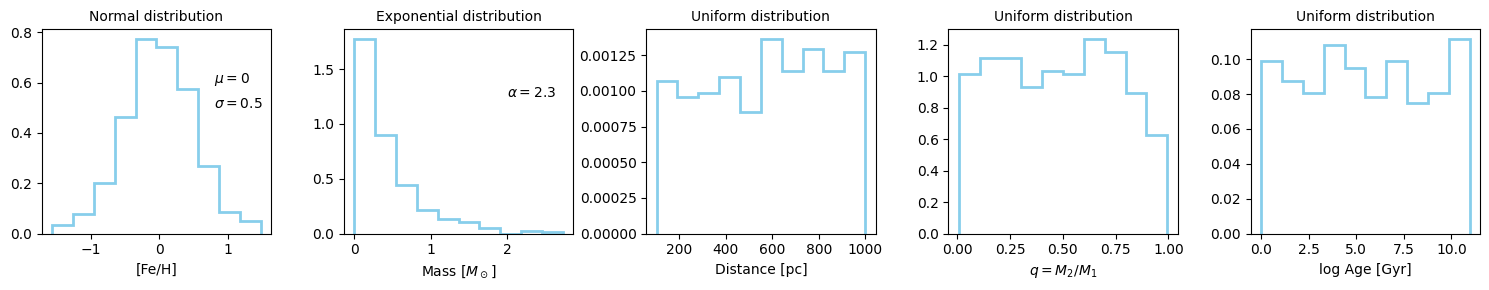

In [3]:
import matplotlib.pyplot as plt
from torch.distributions import Uniform, Normal, Exponential

n_sample = 500

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

normal_distribution = Normal(loc=0.0, scale=0.5)
ax[0].hist(normal_distribution.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[0].set_xlabel(r'[Fe/H]')
ax[0].set_title('Normal distribution', fontsize=10)
#ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].text(0.8,0.6, r'$\mu=0$')
ax[0].text(0.8,0.5, r'$\sigma=0.5$')

exponential_distribution = Exponential(rate=2.3)
ax[1].hist(exponential_distribution.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[1].set_xlabel(r'Mass [$M_\odot$]')
ax[1].set_title('Exponential distribution', fontsize=10)
ax[1].text(2, 1.25, r'$\alpha=2.3$')

uniform_distribution_on_distance = Uniform(low=100.0, high=1000.)
ax[2].hist(uniform_distribution_on_distance.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[2].set_xlabel('Distance [pc]')
ax[2].set_title('Uniform distribution', fontsize=10)
#ax[2].grid(True, linestyle='--', alpha=0.6)

uniform_distribution_on_q = Uniform(low=0.0, high=1.0)
ax[3].hist(uniform_distribution_on_q.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[3].set_xlabel(r'$q=M_2 / M_1$')
ax[3].set_title('Uniform distribution', fontsize=10)
#ax[3].grid(True, linestyle='--', alpha=0.6)

uniform_distribution_on_age = Uniform(low=0.01, high=11.0)
ax[4].hist(uniform_distribution_on_age.sample((n_sample,)), histtype='step', lw=2, density=True, color='skyblue')
ax[4].set_xlabel('log Age [Gyr]')
ax[4].set_title('Uniform distribution', fontsize=10)
#ax[4].grid(True, linestyle='--', alpha=0.6)

fig.tight_layout()
plt.show()

# Set priors

In [4]:
from torch.distributions import (Uniform, Normal, Exponential)
from torch.distributions.transforms import AffineTransform
from torch.distributions.transformed_distribution import TransformedDistribution

from torch import tensor as tt

#from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import prepare_for_sbi


age_bounds = [0.01, 11.0]           # Gyr
mass_bounds = [0.08, 10.0]           # M1
metallicity_bounds = [-2.0, 0.6]    # [Fe/H]
distance_bounds = [10.0, 200.0]     # distance pc

num_simulations = 50_000
num_samples = 10_000

select_prior = 1

if select_prior == 1:
    
    prior = [
    TransformedDistribution(Exponential(rate=tt([2.3])), \
                            AffineTransform(loc=tt([mass_bounds[0]]), scale=tt([mass_bounds[1]]))),                   # M1
    Uniform(tt([0.]), tt([1.])),                                                                                      # q
    Uniform(tt([age_bounds[0]]), tt([age_bounds[1]])),                                                                # age
    TransformedDistribution(Normal(loc=tt([0.0]), scale=tt([0.5])), \
                            AffineTransform(loc=tt([metallicity_bounds[0]]), scale=tt([metallicity_bounds[1]])))      # [Fe/H]
    #Uniform(tt([np.log10(distance_bounds[0])]), tt([np.log10(distance_bounds[1])]))                                  # log10(dist)
    ]

elif select_prior == 2:
    bounds = np.array([
    [mass_bounds[0],  mass_bounds[1]],                           # M1
    [0,      1],                                                 # q
    [age_bounds[0],   age_bounds[1]],                            # (Gyr)
    [metallicity_bounds[0], metallicity_bounds[1]],              # metallicity
    [np.log10(distance_bounds[0]), np.log10(distance_bounds[1])] # log10(distance)
    ])

    bounds = torch.tensor(bounds)
    prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])


sbi_simulator, sbi_prior = prepare_for_sbi(simulator, prior)
inference = method(sbi_prior)

# Generate the simulations. 
## Run if a new posterior is required
### We do this ourselves (instead of using simulate_for_sbi) because if we don't then many will be NaNs and we end up with fewer simulations than we want.

In [5]:
def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
    num_trials, num_simulated, theta, x = (0, 0, [], [])
    
    while num_simulated < num_simulations:
        N = num_simulations - num_simulated
        print(f"Running {N} simulations")
        _theta = proposal.sample((N, ))
        _x = simulator(_theta)
        _x = _x.squeeze(1)  # This will change it from [1, 1, 3] to [1, 3]
        #_theta, _x = simulate_for_sbi(simulator, proposal=proposal, num_simulations=N)
        keep = np.all(np.isfinite(_x).numpy(), axis=1)
        
        theta.extend(np.array(_theta[keep]))
        x.extend(np.array(_x[keep]))

        num_trials += 1
        num_simulated += sum(keep)
        if num_trials > max_trials:
            print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
            break
    theta = torch.tensor(np.vstack(theta))
    x = torch.tensor(np.vstack(x))
    return (theta, x)

In [4]:
# def simulate_for_sbi_strict(simulator, proposal, num_simulations, max_trials=np.inf):
#     num_trials, num_simulated, theta, x = (0, 0, [], [])

#     with tqdm(total=num_simulations) as pbar:
    
#         while num_simulated < num_simulations:
#             time.sleep(0.1)

#             N = num_simulations - num_simulated
#             print(f"Running {N} simulations")
#             _theta = proposal.sample((N, ))
#             _x = simulator(_theta)
#             _x = _x.squeeze(1)  # This will change it from [1, 1, 3] to [1, 3]
#             keep = np.all(np.isfinite(_x).numpy(), axis=1)
            
#             theta.extend(np.array(_theta[keep]))
#             x.extend(np.array(_x[keep]))

#             num_trials += 1
#             num_simulated += sum(keep)

#             pbar.update(sum(keep))

#             if num_trials > max_trials:
#                 print(f"Warning: exceeding max trials ({max_trials}) with {num_simulated} / {num_simulations} simulations")
#                 break
    
#     theta = torch.tensor(np.vstack(theta))
#     x = torch.tensor(np.vstack(x))
#     return (theta, x)

# Build or load posterior

In [6]:
posterior_path = "./data/train_posterior_v2.pkl"
#posterior_path = "./data/train_posterior.pkl"

if os.path.exists(posterior_path):
    print(f"Pre-loading posterior from {posterior_path}")
    with open(posterior_path, "rb") as fp:
        posterior, (theta, x) = pickle.load(fp)

else:
    theta, x = simulate_for_sbi_strict(sbi_simulator, sbi_prior, num_simulations)
    density_estimator = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(density_estimator) # mcmc_method='slice_np' sample_with='vi', vi_method='rKL'
    
    with open(posterior_path, "wb") as fp:
        pickle.dump((posterior, (theta, x)), fp)
        
    print(f"Saved posterior to {posterior_path}")

Running 50000 simulations
Running 39043 simulations
Running 30604 simulations
Running 24088 simulations
Running 18949 simulations
Running 14928 simulations
Running 11691 simulations
Running 9181 simulations
Running 7210 simulations
Running 5642 simulations
Running 4448 simulations
Running 3471 simulations
Running 2754 simulations
Running 2138 simulations
Running 1666 simulations
Running 1295 simulations
Running 999 simulations
Running 792 simulations
Running 632 simulations
Running 499 simulations
Running 391 simulations
Running 309 simulations
Running 240 simulations
Running 186 simulations
Running 146 simulations
Running 118 simulations
Running 101 simulations
Running 88 simulations
Running 62 simulations
Running 48 simulations
Running 40 simulations
Running 28 simulations
Running 21 simulations
Running 20 simulations
Running 16 simulations
Running 11 simulations
Running 9 simulations
Running 5 simulations
Running 5 simulations
Running 4 simulations
Running 2 simulations
Running 2 si

In [7]:
x.shape, theta.shape

(torch.Size([50000, 3]), torch.Size([50000, 4]))

In [ ]:
# mask = (x[:, 0] >= 1.) & (x[:, 0] <= 10.)
# x = x[mask]
# theta = theta[mask]
# x.shape, theta.shape

In [ ]:
#['par','b','g','r','j','h','k','w1','w2']
# g, bp, rp, dist

In [8]:
#x = x[:,0:4]
x

tensor([[ 5.3549,  4.6201,  5.0777],
        [ 9.7049,  8.2511,  9.0319],
        [ 4.1981,  3.6634,  4.0092],
        ...,
        [10.3730,  8.8383,  9.6467],
        [10.3414,  8.6842,  9.5387],
        [10.7429,  9.2219, 10.0251]])

In [9]:
x[:,0].min(), x[:,0].max()

(tensor(-6.3175), tensor(13.6829))

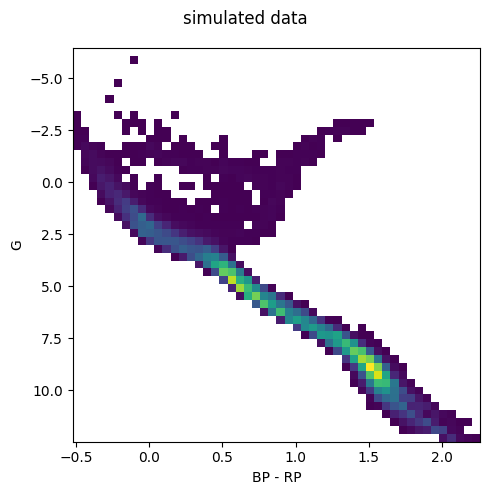

In [14]:
# b_mag, r_mag, g_mag
g_mag = x.numpy()[:,2]# - 5* np.log10(x.numpy()[:,3]) + 5
color_mag = x.numpy()[:,0] - x.numpy()[:,1]

#g_mag = x.numpy()[:,2] - 5* np.log10(1000/x.numpy()[:,0]) + 5
#color_mag = x.numpy()[:,1] - x.numpy()[:,3]

fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('simulated data')
ax.hist2d(color_mag, g_mag, bins=50, density=False, cmin=2)
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')
ax.invert_yaxis()
fig.tight_layout()

# Test for one star

In [15]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

[1.8  0.75 0.5  0.01]
g_mag, bp_mag, rp_mag, dist
tensor([[1.7816, 1.5030, 1.6845]], dtype=torch.float64)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 4])


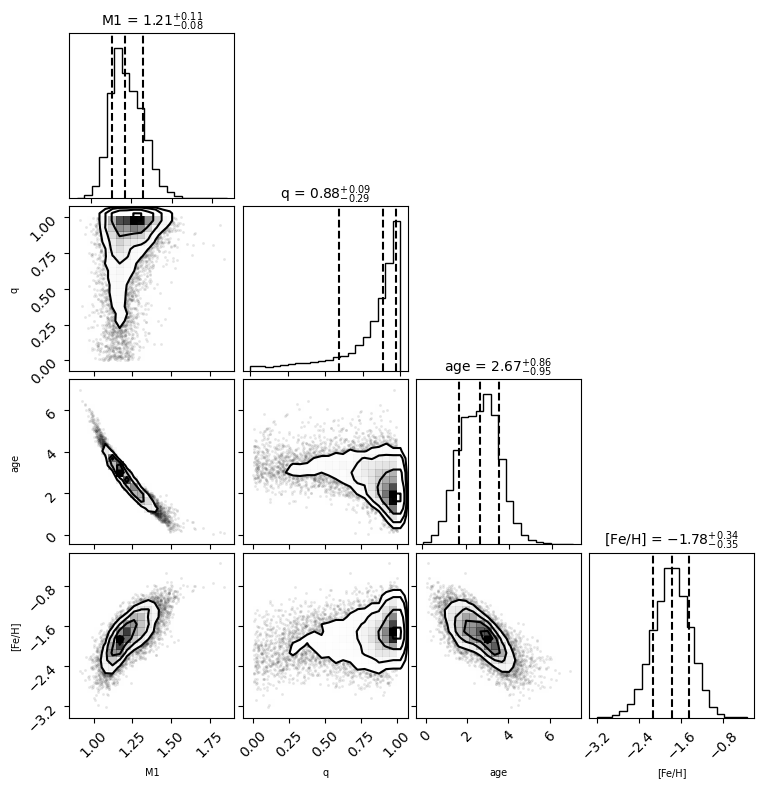

In [24]:
mass = 1.8
q = 0.75
age = 0.5
metallicity = 0.01
#dist = 500 

truth = np.array([mass, q, age, metallicity]) # np.log10(dist)
print(truth)
observation = simulator(truth)
print('g_mag, bp_mag, rp_mag, dist')
print(observation)
assert np.all(np.isfinite(np.array(observation)))

samples = posterior.sample((num_samples,), x=torch.tensor(observation), show_progress_bars=True) # sample_with='mcmc'
# num_samples

labels = ("M1", "q", "age", "[Fe/H]")
print(samples.shape)
n_dim = samples.numpy().shape[1]
fig, _ = plt.subplots(n_dim, n_dim, figsize=(8,8))
fig = corner.corner(samples.numpy(), labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, fig=fig,
                    title_kwargs={"fontsize":10}, label_kwargs=dict(fontsize=7), truth_color='C0')
# truths=truth

# Read data from star cluster

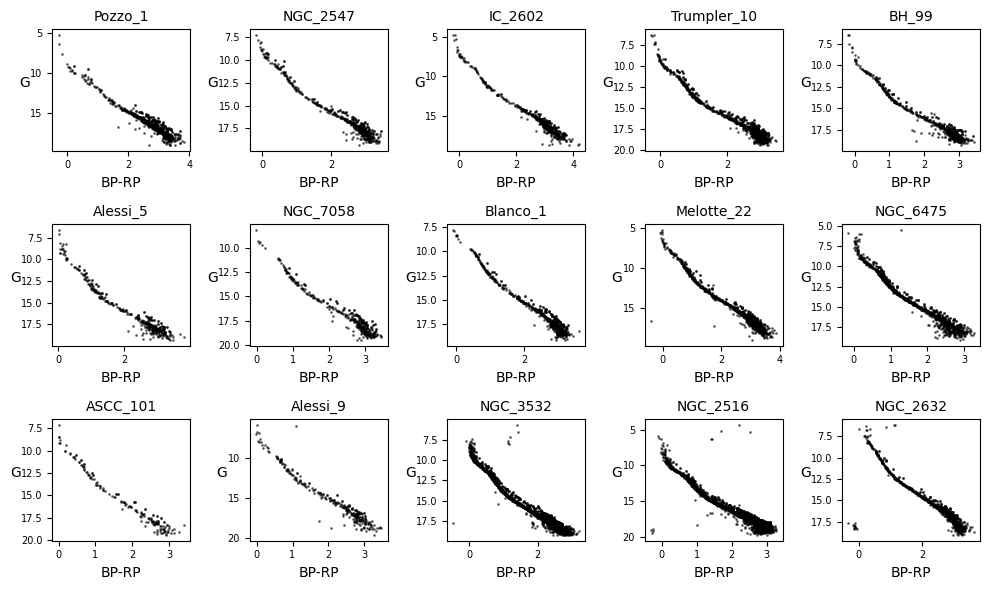

In [25]:
list_clusters = ['Pozzo_1','NGC_2547','IC_2602','Trumpler_10','BH_99','Alessi_5','NGC_7058','Blanco_1',\
                 'Melotte_22','NGC_6475','ASCC_101','Alessi_9','NGC_3532','NGC_2516','NGC_2632']

fig, axes = plt.subplots(3,5, figsize=(10,6))

for cluster,ax in zip(list_clusters, axes.flat):
    df = pd.read_csv('./data/final_data/{}.csv'.format(cluster))

    ax.set_title(cluster, fontsize=10)
    ax.scatter(df['bp_rp'], df['phot_g_mean_mag'], s=1, marker='o', c='k', alpha=0.5)
    ax.invert_yaxis()
    ax.set_xlabel('BP-RP')
    ax.set_ylabel('G', rotation=0)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
fig.tight_layout()
plt.show()

In [35]:
cluster = 'NGC_6475'
remove_stars = pd.read_csv('./data/SGs_and_RGBs_clusters_sourceid.csv')
list_remove_stars = remove_stars['source_id'][(remove_stars['cluster'] == cluster)].to_list()
df = pd.read_csv('/Users/steven/Documents/members_sample/members_sample1/{}.csv'.format(cluster))
df = df[~df['source_id'].isin(list_remove_stars)]
df

,Unnamed: 0.1,Unnamed: 0,source_id,ra,ra_error,dec,dec_error,l,b,parallax,...,ebpminrp_gspphot,nu_eff_used_in_astrometry,pseudocolour,ecl_lat,ecl_lon,astrometric_params_solved,parallax_corrected,bp_rp,g_rp,labels_5F
0,0,0,4039928736355128832,267.965071,0.166675,-37.114610,0.131175,353.643826,-5.320378,3.384632,...,0.5541,0.000000,1.286634,-13.687125,268.329985,95,3.348066,3.044678,1.293276,NaN
1,1,1,4039931725653660544,268.282551,0.017476,-37.110006,0.014364,353.775611,-5.536959,3.651388,...,0.1019,1.492162,0.000000,-13.679128,268.590470,31,3.617150,1.106294,0.633109,NaN
2,2,2,4039018512529423360,270.692256,0.133177,-35.161469,0.113317,356.443728,-6.271583,3.575582,...,1.8869,0.000000,1.228587,-11.723577,270.578008,95,3.575582,2.590826,1.309832,NaN
3,3,3,4039009789556712832,270.615784,0.017410,-35.403758,0.014458,356.200010,-6.334178,3.469499,...,0.0974,1.561982,0.000000,-11.965574,270.513077,31,3.437812,0.804107,0.500519,NaN
4,4,4,4039012430851778688,270.453771,0.017270,-35.336052,0.014611,356.195172,-6.185807,3.673141,...,0.1689,1.468471,0.000000,-11.897368,270.378312,31,3.629934,1.226267,0.696302,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,705,4040523365984273152,268.896855,0.019426,-35.700672,0.015262,355.250057,-5.261464,3.299408,...,0.1385,1.513542,0.000000,-12.264902,269.083267,31,3.277859,1.002070,0.586004,-1.0
1231,1231,736,4042890687605169792,271.176948,0.020015,-32.582954,0.016634,358.908044,-5.376907,3.646853,...,0.2284,1.452168,0.000000,-9.147776,271.004481,31,3.603499,1.324075,0.739868,-1.0
1232,1232,894,4040833222314531584,268.691962,0.033357,-34.617622,0.031334,356.108073,-4.575691,3.345888,...,0.2656,1.381657,0.000000,-11.183323,268.902740,31,3.301412,1.767970,0.931588,-1.0
1233,1233,933,4038963575736059904,270.352597,0.020350,-35.696946,0.017495,355.837572,-6.289044,3.663624,...,0.1478,1.442850,0.000000,-12.258024,270.293042,31,3.620401,1.363305,0.747481,-1.0


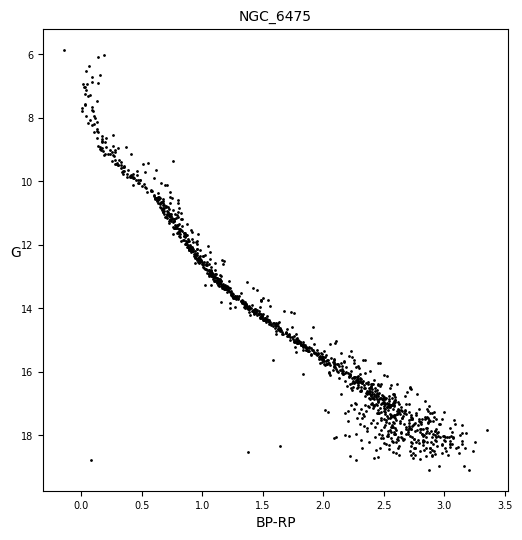

In [36]:
fig, ax = plt.subplots(figsize=(6,6))

ax.set_title(cluster, fontsize=10)
ax.scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], s=1, marker='o', c='k')
ax.invert_yaxis()
ax.set_xlabel('BP-RP')
ax.set_ylabel('G', rotation=0)
ax.tick_params(axis='both', which='major', labelsize=7)

In [38]:
L = 4 # number of parameters
num_injections = len(df)
parameters = np.empty((num_injections, num_samples, L))
# b_mag, r_mag, g_mag

for i in tqdm(range(len(df))):
    observation_per_star = df[['phot_bp_mean_mag','phot_rp_mean_mag','phot_g_mean_mag']].to_numpy()
    observation_per_star = torch.from_numpy(observation_per_star)
    parameters[i] = posterior.sample((num_samples,), x=observation_per_star, show_progress_bars=True)
    break

  0%|          | 0/1234 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1234 [00:28<?, ?it/s]


KeyboardInterrupt: 

# Read data from estimations

In [15]:
binaries = pd.read_csv('./data_artem/binaries.csv')
del binaries['Unnamed: 0']
binaries['g_abs'] = binaries['RPmag'] - 5*np.log10(1000*binaries['Dist50']) + 5
binaries

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,M1,q_ratio,age,fe_h,log_distance,g_abs
0,3839689084608000384,6.2382,5.9581,6.3554,10.974,0.09114,1.033563,0.623762,7.370112,-2.250378,1.952739,1.159555
1,5870261656933718784,11.1995,10.5217,11.7148,11.055,0.09046,0.573231,0.950858,2.984773,-0.863638,1.956973,5.739417
2,5472035042322559232,8.1138,7.6623,8.3673,10.214,0.09849,1.085973,0.448749,3.447530,-1.912268,2.007660,2.695339
3,346081253464896128,8.8243,8.2894,9.1869,10.171,0.09843,1.097300,0.473487,1.973911,-1.934580,1.994598,3.323763
4,2005707778312337280,10.3786,9.6747,10.9237,13.395,0.07470,0.606492,0.851098,0.507758,-2.028281,1.872658,5.308097
5,4327126469222618112,12.6003,11.6351,13.5525,13.697,0.07305,0.339556,0.807854,0.505116,-1.215874,1.863289,7.316999
6,4485972467412021376,8.2252,7.7437,8.5253,18.786,0.05325,6.973423,0.668826,0.129320,-1.538140,2.224850,4.112102
7,5729803105228876800,14.5245,13.3414,15.8688,12.188,0.08208,0.041714,0.242415,0.231278,-1.463647,1.911670,8.770213
8,2292898390100418048,12.2164,11.2521,13.0985,14.192,0.07047,0.359056,0.908900,0.442354,-1.918948,1.846484,7.012079
9,2897454348851010944,10.8892,10.2238,11.4000,11.575,0.08661,0.592874,0.941906,0.509878,-1.339964,1.937858,5.535960


In [16]:
data_binary

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,RUWE,[Fe/H],mass,mass_error,flag,bp_rp,g_abs
0,2875125810310195712,8.3483,7.8431,8.6769,20.194,0.04952,14.26,-0.198054,1.050534,0.039871,1.0,0.8338,4.369197
1,2854954135627103488,8.7198,8.2686,9.0063,11.564,0.08655,4.38,0.117633,1.119408,0.058134,1.0,0.7377,3.582265
2,2880986374788373376,11.7497,10.9730,12.4039,11.104,0.09007,1.23,0.170862,0.696993,0.039649,1.0,1.4309,6.200099
3,2746869015880925696,12.8457,11.8978,13.7273,10.750,0.09306,1.55,-0.557720,0.576496,0.040613,1.0,1.8295,7.053985
4,2772904695310603520,8.5413,7.8083,8.9998,33.259,0.03007,1.61,-0.532630,0.830923,0.038654,1.0,1.1915,5.417633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20905,2449723662011846528,9.0460,8.5649,9.3120,12.488,0.08012,5.68,-0.864598,1.128512,0.044576,1.0,0.7471,4.046195
20906,2747165574782671872,14.2360,13.1069,15.5405,11.236,0.08901,1.22,-1.563757,0.423861,0.039397,1.0,2.4336,8.359706
20907,2332946559249914240,9.2790,8.8052,9.5798,10.334,0.09678,2.16,-0.362188,1.154735,0.089841,1.0,0.7746,3.876272
20908,2335088098663208320,11.3043,10.4918,12.0154,11.053,0.09047,1.66,-0.290771,0.777653,0.040177,1.0,1.5236,5.709277


In [21]:
data_binary[0:1]

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,RUWE,[Fe/H],mass,mass_error,flag,bp_rp,g_abs
0,2875125810310195712,8.3483,7.8431,8.6769,20.194,0.04952,14.26,-0.198054,1.050534,0.039871,1.0,0.8338,4.369197


In [22]:
data_binary[1:2]

,GaiaEDR3,Gmag,RPmag,BPmag,Plx,Dist50,RUWE,[Fe/H],mass,mass_error,flag,bp_rp,g_abs
1,2854954135627103488,8.7198,8.2686,9.0063,11.564,0.08655,4.38,0.117633,1.119408,0.058134,1.0,0.7377,3.582265


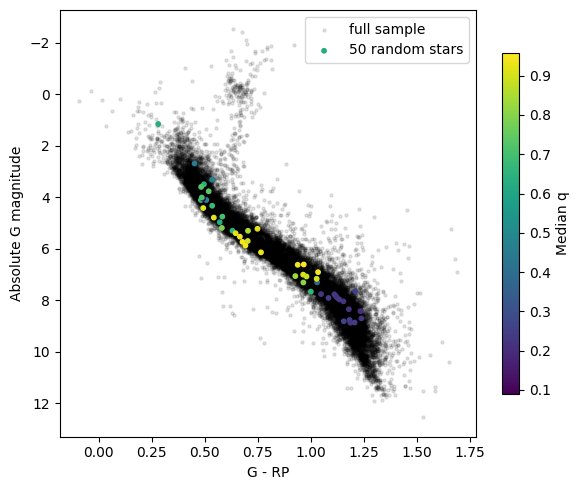

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(data_binary['Gmag'] - data_binary['RPmag'], data_binary['g_abs'], s=5, c='k', alpha=0.1, label='full sample')
plot = ax.scatter(binaries['Gmag'] - binaries['RPmag'], binaries['g_abs'], s=10, alpha=1, c=binaries['q_ratio'], label='%s random stars'%len(binaries))
cbar = fig.colorbar(plot, label='Median q', shrink=0.8)
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('G - RP')
ax.set_ylabel('Absolute G magnitude')
plt.tight_layout()

# Read data for a cluster

tensor([[  2.8389,   9.4262,   8.7873, 186.0027],
        [  3.6939,  10.3606,   9.5485, 185.0563],
        [  3.9296,  10.5895,   9.7409, 183.6977],
        [  4.1376,  10.7494,   9.8943, 179.3638],
        [  5.0278,  11.8319,  10.7596, 185.7776],
        [  5.9467,  12.8715,  11.5876, 187.0194],
        [  6.0186,  13.0088,  11.6211, 186.9411],
        [  7.1049,  14.1968,  12.6188, 186.3743],
        [  7.3619,  14.3675,  12.7251, 176.2112],
        [  7.3302,  14.5300,  12.8434, 190.2076]], dtype=torch.float64)


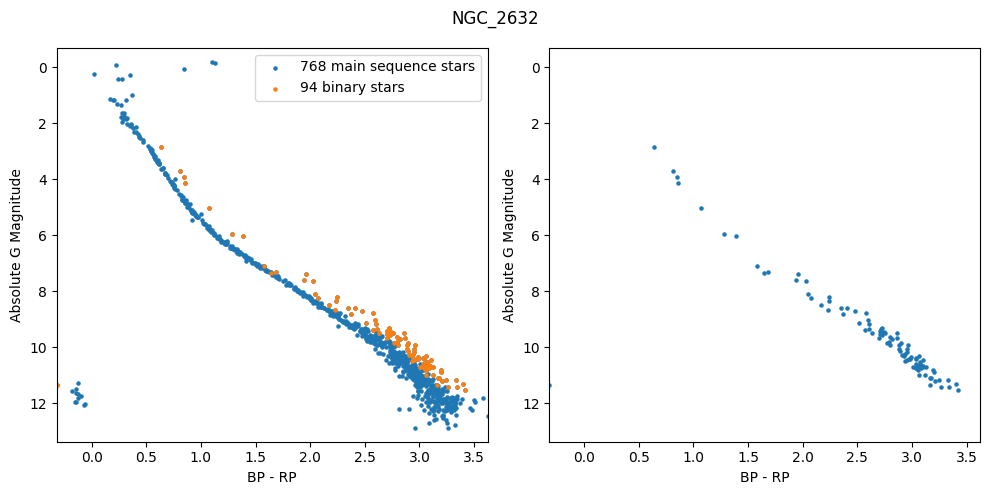

In [35]:
cluster = 'NGC_2632'#'NGC_2682'
df = pd.read_csv('../data_masses/{}.csv'.format(cluster))
#df = pd.read_csv('/home/steven/Dropbox/data_open_clusters/{}.csv'.format(cluster))
df['log_dist'] = np.log10(df['distance'])
df['g_mag'] = df['phot_g_mean_mag'] - 5*df['log_dist'] + 5
condition = (df['binary'] == True)

df_binary = df[condition]
observation_per_cluster = df_binary[['g_mag','phot_bp_mean_mag','phot_rp_mean_mag','distance']].to_numpy()
observation_per_cluster = torch.from_numpy(observation_per_cluster)
print(observation_per_cluster[:10,:])

d_edges = 0.5
custom_xlim = (df['bp_rp'].min(), df['bp_rp'].max())
custom_ylim = (df['g_mag'].min()-d_edges, df['g_mag'].max()+d_edges)

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle(cluster)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

ax[0].scatter(df['bp_rp'], df['g_mag'], s=5, label='%s main sequence stars'%(len(df)-len(df[condition])))
#ax[0].scatter(df['bp_rp'][condition], df['g_mag'][condition], s=5, label='%s binary stars'%(len(df[condition])))
ax[0].scatter(observation_per_cluster[:,1].numpy() - observation_per_cluster[:,2].numpy(), observation_per_cluster[:,0].numpy(), \
              s=5, label='%s binary stars'%(len(df[condition])))
ax[0].set_xlabel('BP - RP')
ax[0].set_ylabel('Absolute G Magnitude')
ax[0].legend()
ax[0].invert_yaxis()

ax[1].scatter(df['bp_rp'][condition], df['g_mag'][condition], s=5)
ax[1].set_xlabel('BP - RP')
ax[1].set_ylabel('Absolute G Magnitude')
ax[1].invert_yaxis()

fig.tight_layout()

In [24]:
observation_per_cluster[:-7,:]#.shape

tensor([[  2.8389,   9.4262,   8.7873, 186.0027],
        [  3.6939,  10.3606,   9.5485, 185.0563],
        [  3.9296,  10.5895,   9.7409, 183.6977],
        [  4.1376,  10.7494,   9.8943, 179.3638],
        [  5.0278,  11.8319,  10.7596, 185.7776],
        [  5.9467,  12.8715,  11.5876, 187.0194],
        [  6.0186,  13.0088,  11.6211, 186.9411],
        [  7.1049,  14.1968,  12.6188, 186.3743],
        [  7.3619,  14.3675,  12.7251, 176.2112],
        [  7.3302,  14.5300,  12.8434, 190.2076],
        [  7.3712,  14.7082,  12.7491, 187.0150],
        [  7.6476,  15.0108,  12.9806, 185.5935],
        [  7.5921,  14.9906,  13.0489, 193.5494],
        [  8.1020,  15.4437,  13.3959, 182.2865],
        [  8.2114,  15.7336,  13.4915, 186.4999],
        [  8.2444,  15.6694,  13.5943, 188.2694],
        [  8.3555,  15.8241,  13.5854, 182.1640],
        [  8.5079,  15.9708,  13.7991, 186.0354],
        [  8.5907,  16.2007,  13.8512, 187.3591],
        [  8.6809,  16.1324,  13.9022, 181.3603],


# Do sampling for each one.

In [12]:
num_injections = len(observation_per_cluster)
num_injections, num_samples

(94, 2000)

In [15]:
#dir(posterior)

In [16]:
#posterior.sample.__doc__

In [28]:
observation_per_cluster[2,:]

tensor([  2.3346,  10.7600,  10.2512, 444.2360], dtype=torch.float64)

In [29]:
L = 5 # number of parameters
all_samples = np.empty((num_injections, num_samples, L))

for i in tqdm(range(len(observation_per_cluster))):
    obs = observation_per_cluster[i,:]
    all_samples[i] = posterior.sample((num_samples,), x=obs, show_progress_bars=False) # sample_with='mcmc'

 22%|██▏       | 26/117 [00:03<00:20,  4.41it/s]WARNING:root:Only 0.550% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1989 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 25%|██▍       | 29/117 [00:07<00:57,  1.54it/s]WARNING:root:Only 0.700% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 26%|██▌       | 30/117 [00:10<01:55,  1.32s/it]WARNING:root:Only 0.700% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1986 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 26%|██▋       | 31/117 [00:13<02:29,  1.74

In [ ]:
# #_, L = sbi_prior.sample((1, )).shape
# L = 5 # number of parameters

# all_samples = np.empty((num_injections, num_samples, L))

# for i, obs in enumerate(tqdm(observation_per_cluster)):
#     all_samples[i] = posterior.sample((num_samples,), x=obs, show_progress_bars=False) # sample_with='mcmc'

In [ ]:
# Let's see where the truth was as a percentile in each injection.

In [30]:
all_samples.shape, len(all_samples)

((117, 2000, 5), 117)

In [31]:
#100*3000 - 160000 # empanadas
all_samples[0]

array([[ 1.71687019,  0.20461966,  1.22802162, -0.52657241,  2.64184141],
       [ 1.86904979,  0.12335108,  0.89641601, -0.64948767,  2.64153886],
       [ 1.59936488,  0.46477675,  1.30501401, -1.10429144,  2.64164591],
       ...,
       [ 1.56489849,  0.89983886,  1.27440882, -0.97147095,  2.64160442],
       [ 2.32391453,  0.33412316,  0.44948256,  0.23930401,  2.64194512],
       [ 2.28023648,  0.38174421,  0.47567874,  0.22642089,  2.64161205]])

# Get params from sampling per star

In [53]:
estimated_params = np.zeros((len(all_samples), 5)) 
#errors_up = np.zeros_like(estimated_params) 
#errors_down = np.zeros((len(all_samples), 4)) 

for i in range(len(all_samples)):
    params = np.percentile(all_samples[i], 50, axis=0)
    for j in range(len(params)):
        estimated_params[i,j] = params[j]

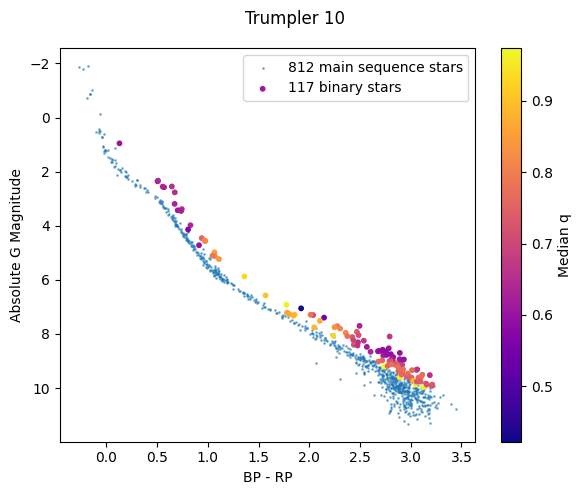

In [54]:
fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle(cluster. replace('_',' '))
ax.scatter(df['bp_rp'], df['g_mag'], s=1, c='C0', alpha=0.5, label='%s main sequence stars'%(len(df)-len(df[condition])))
sc = ax.scatter(df['bp_rp'][condition], df['g_mag'][condition], s=10, label='%s binary stars'%(len(df[condition])), c=estimated_params[:,1],\
                cmap='plasma')
ax.set_xlabel('BP - RP')
ax.set_ylabel('Absolute G Magnitude')
ax.invert_yaxis()
ax.legend()
fig.colorbar(sc, label='Median q', location='right', ax=ax)
fig.tight_layout()
fig.savefig('./images/binary_test.png', bbox_inches='tight')

In [65]:
estimated_params

array([[ 1.96594959e+00,  6.06719524e-01,  7.49792039e-01,
        -2.64571697e-01,  2.64166582e+00],
       [ 1.38461351e+00,  6.15859956e-01,  2.12876236e+00,
        -2.02687651e-01,  2.62659824e+00],
       [ 1.39850068e+00,  6.38682812e-01,  2.11362314e+00,
        -1.74149796e-01,  2.64793015e+00],
       [ 1.34532237e+00,  6.50905758e-01,  3.08234727e+00,
        -6.73831347e-03,  2.62092102e+00],
       [ 1.33846194e+00,  6.45657718e-01,  2.44573975e+00,
        -1.34777054e-01,  2.63187206e+00],
       [ 1.33711576e+00,  6.24984413e-01,  2.61611283e+00,
        -1.17866553e-01,  2.63852453e+00],
       [ 1.30397105e+00,  6.51654303e-01,  3.50954139e+00,
         2.93800021e-02,  2.61598551e+00],
       [ 1.19018745e+00,  6.33120090e-01,  3.94148743e+00,
        -1.37960995e-02,  2.63583601e+00],
       [ 1.17384553e+00,  6.51273251e-01,  4.83569884e+00,
         1.16820421e-01,  2.63911724e+00],
       [ 1.14623135e+00,  6.09878033e-01,  4.53937531e+00,
         2.24275747e-03

In [66]:
df_binary

,Unnamed: 0,source_id,ra,ra_error,dec,dec_error,l,b,parallax,parallax_error,...,distance,x,y,z,g_mag,mass_predicted,binary,log_dist,M1,q_ratio
16,16,5524172955997468672,131.982411,0.014929,-42.589472,0.016745,262.902515,0.590560,2.288712,0.018811,...,439.263751,-54.271586,-435.874684,4.527505,0.953672,0.398852,True,2.642725,0.986230,0.599276
50,50,5330276863582453632,135.705815,0.010570,-46.206029,0.011268,267.380575,0.282447,2.376348,0.013569,...,422.971461,-19.330223,-422.524380,2.085078,2.357265,0.237526,True,2.626311,0.587567,0.590443
54,54,5524153542751548800,132.421855,0.012390,-42.443742,0.013544,262.993803,0.933809,2.268921,0.015726,...,444.236000,-54.179192,-440.860322,7.239855,2.334613,0.227848,True,2.647614,0.613076,0.601119
55,55,5523934911734512384,132.585425,0.013013,-42.974942,0.014140,263.480942,0.690166,2.408563,0.016728,...,417.513000,-47.398307,-414.783334,5.029098,2.548037,0.218834,True,2.620670,0.589817,0.594142
59,59,5523369243062322176,129.809169,0.008261,-43.035190,0.009541,262.266105,-0.937554,2.348214,0.010609,...,428.155085,-57.610098,-424.203692,-7.005770,2.554124,0.211925,True,2.631601,0.562983,0.617008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,613,5529511875230699392,128.206129,0.077031,-38.834348,0.092764,258.181794,0.621624,2.291340,0.104206,...,436.425879,-89.377801,-427.149549,4.734857,9.747679,-0.273360,True,2.639910,0.000000,0.000000
620,620,5525383483944324992,132.227254,0.063275,-41.255249,0.069685,261.980804,1.572450,2.434311,0.081521,...,417.207522,-58.180514,-412.972244,11.448580,9.872139,-0.274580,True,2.620352,0.000000,0.000000
641,641,5523937175177409408,132.663365,0.082287,-42.863544,0.091023,263.431103,0.804986,2.444204,0.106002,...,409.131234,-46.799082,-406.405184,5.747960,9.967445,-0.277009,True,2.611863,0.000000,0.000000
646,646,5524185188069302272,131.787996,0.076497,-42.513600,0.096093,262.753524,0.526745,2.361597,0.099826,...,429.921417,-54.227067,-426.469493,3.952397,9.874723,-0.277697,True,2.633389,0.000000,0.000000


In [69]:
df_binary['M1'] = 0
df_binary['q_ratio'] = 0
df_binary.reset_index(inplace=True)

for i in range(len(df_binary)):
    df_binary['M1'][i] = estimated_params[i,0]
    df_binary['q_ratio'][i] = estimated_params[i,1]

In [76]:
df_binary.to_csv('../data_masses/binaries/{}.csv'.format(cluster))

In [74]:
print(df_binary['q_ratio'].min(), df_binary['q_ratio'].max())
print(df_binary['M1'].min(), df_binary['M1'].max())

0.4224949926137924 0.9737186133861542
0.39103399217128754 1.9659495949745178


In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle(cluster)

for i in range(len(estimated_params[:,1])):
    if estimated_params[:,1][i] > 0.5:
        color_ = df['phot_bp_mean_mag'][i] - df['phot_rp_mean_mag'][i]
        ax.scatter(color_, df['phot_g_mean_mag'][i], cmap='viridis', c=estimated_params[:,1][i], s=5)

#sc = ax.scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], cmap='viridis', c=estimated_params[:,1], s=5)
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')
ax.invert_yaxis()
#fig.colorbar(sc, label='Median q', location='right', ax=ax) 
fig.tight_layout()

In [ ]:
from scipy.stats import percentileofscore as pos
true_theta = np.array(true_theta)

percentiles = np.empty((num_injections, L))
for i, this_theta in enumerate(tqdm(np.array(true_theta))):
    for j, t in enumerate(this_theta):
        percentiles[i, j] = pos(all_samples[i, :, j], t)

In [ ]:
fig, axes = plt.subplots(2, 2)
for i, ax in enumerate(axes.flat):
    ax.hist(percentiles[:, i])
    ax.set_xlabel(labels[i])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    lower, mean, upper = np.percentile(all_samples[:, :, i], [16, 50, 84], axis=1)
    yerr_pos = upper - mean
    yerr_neg = mean - lower
    ax.errorbar(
        true_theta[:, i],
        mean,
        yerr=(yerr_neg, yerr_pos),
        fmt='o'
    )
    limits = np.array([ax.get_xlim(), ax.get_ylim()])
    limits = (np.min(limits), np.max(limits))
    ax.plot(limits, limits, c="#666666", ls=":", zorder=-1)
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    ax.set_title(labels[i])
    ax.set_xlabel(f"injected")
    ax.set_ylabel(f"recovered")

In [ ]:
## TODO: Check that this is the right thing to be doing here!
fig, ax = plt.subplots(figsize=(6, 6))

for i, label in enumerate(labels):
    x = percentiles.T[i]
    y = true_theta.T[i]
    ax.plot(
        np.cumsum(x)/np.sum(x),
        np.cumsum(y)/np.sum(y),
        label=label
    )
limits = [0, 1]
ax.plot(limits, limits, c="#666666", zorder=-1, ls=":")
ax.legend()
ax.set_xlim(limits)
ax.set_ylim(limits)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

from matplotlib.colors import LogNorm 
def plot_binned_statistic(x, y, z, bins=100, function=np.nanmedian,
                          xlabel=None, ylabel=None, zlabel=None,
                          ax=None, colorbar=False, figsize=(8, 8),
                          vmin=None, vmax=None, min_entries_per_bin=None,
                          subsample=None, mask=None, full_output=False, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.figure
    
    finite = np.isfinite(x * y * z)
    if mask is not None:
        finite *= mask
    if subsample is not None:
        idx = np.where(finite)[0]
        if subsample < 1:
            subsample *= idx.size
        if int(subsample) > idx.size:
            finite = idx
        else:
            finite = np.random.choice(idx, int(subsample), replace=False)
    
    H, xedges, yedges, binnumber = binned_statistic_2d(
        x[finite], y[finite], z[finite],
        statistic=function, bins=bins)

    if min_entries_per_bin is not None:
        if function != "count":
            H_count, xedges, yedges, binnumber = binned_statistic_2d(
                x[finite], y[finite], z[finite],
                statistic="count", bins=bins)

        else:
            H_count = H

        H[H_count < min_entries_per_bin] = np.nan


    if (vmin is None or vmax is None) and "norm" not in kwargs:
        vmin_default, med, vmax_default = np.nanpercentile(H, kwargs.pop("norm_percentiles", [5, 50, 95]))
        if vmin is None:
            vmin = vmin_default
        if vmax is None:
            vmax = vmax_default
    
    imshow_kwds = dict(
        vmin=vmin, vmax=vmax,
        aspect=np.ptp(xedges)/np.ptp(yedges), 
        extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
        cmap="inferno",
        interpolation="bilinear")
    imshow_kwds.update(kwargs)
    
    image = ax.imshow(H.T, **imshow_kwds)
    if colorbar:
        cbar = plt.colorbar(image, ax=ax)
        if zlabel is not None:
            cbar.set_label(zlabel)

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    #fig.tight_layout()

    return (fig, image) if full_output else fig

In [ ]:
c

In [ ]:
# Plot the training set and the injection set in data coords
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# b, r, g
c_index = 1 # q
c = x.T[c_index]
#vmin, vmax = (min(c), max(c))
plot_binned_statistic(
    np.array(x.T[0] - x.T[1]),
    np.array(x.T[2]),
    np.array(x.T[2]),
    norm=LogNorm(),
    function="count",
    min_entries_per_bin=1,
    interpolation="nearest",
    bins=200,
    ax=axes[0]
)

axes[1].scatter(
    true_obs.T[0] - true_obs.T[1],
    true_obs.T[2],
)
for ax in axes:
    ax.set_xlabel("BP-RP")
    ax.set_ylabel("M_G")
axes[1].set_xlim(axes[0].get_xlim())
axes[1].set_ylim(axes[0].get_ylim())

axes[0].set_title("Training set")
axes[1].set_title("Injection set")

In [ ]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
bad_index = np.argmax(delta_q)
bad_theta = true_theta[bad_index]
print(bad_theta)

In [ ]:
print(all_samples.shape)
fig = analysis.pairplot(
    all_samples[bad_index], 
    points=bad_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

In [ ]:
delta_q = np.abs(true_theta[:, 1] - np.mean(all_samples[:, :, 1], axis=1))
good_index = np.argmin(delta_q)
good_theta = true_theta[good_index]
print(good_theta)

In [ ]:
fig = analysis.pairplot(
    all_samples[good_index], 
    points=good_theta,
    labels=labels,
    figsize=(10, 10),
    points_colors=["tab:red"]
)

# Plot

In [62]:
import numpy as np
import astropy.coordinates as apycoords
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
import pandas as pd

# Our paper

In [35]:
catalog = 'J/A+A/689/A18/members' #Exploring
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
df = query.to_pandas()
df = df.fillna(0)
df['d'] = 1000. / df['Plx']
df

,Cluster,GaiaDR3,RA_ICRS,DE_ICRS,pmRA,pmDE,Plx,PlxCorr,_RA.icrs,_DE.icrs,d
0,ASCC_10,125596289824676864,50.703770,33.515756,-2.054702,-1.767013,1.324568,1.291788,50.703781,33.515764,754.963390
1,ASCC_10,125638758461159040,50.348322,33.726894,-1.167929,-2.679550,1.311128,1.269733,50.348328,33.726905,762.701993
2,ASCC_10,125646248884232448,50.763114,33.678626,-1.895948,-1.781295,1.347874,1.306567,50.763125,33.678634,741.909063
3,ASCC_10,125646558121874176,50.753848,33.699988,-1.707604,-3.275335,1.340151,1.307543,50.753857,33.700003,746.184712
4,ASCC_10,125673736674769792,50.713269,34.083176,-2.139180,-3.446868,1.348603,1.306908,50.713280,34.083191,741.507901
...,...,...,...,...,...,...,...,...,...,...,...
87703,vdBergh_83,2918885307946726912,101.137289,-27.528837,-3.010456,4.709788,1.067329,1.029433,101.137305,-27.528858,936.918452
87704,vdBergh_83,2918893382485209600,101.244716,-27.429275,-3.294288,4.128923,1.080757,1.052912,101.244733,-27.429293,925.277698
87705,vdBergh_83,2920028520863715328,101.254002,-27.043379,-1.764080,3.952414,0.931194,0.902875,101.254011,-27.043397,1073.890216
87706,vdBergh_83,2920038008450358272,101.384512,-26.864962,-1.764122,4.153722,0.915774,0.876716,101.384521,-26.864980,1091.971968


In [67]:
catalog = 'J/A+A/689/A18/clusters' #Exploring
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
df = query.to_pandas()
df = df.rename(columns={'Cluster':'cluster'})
our = df.fillna(0)
our = our[['cluster','logAge']]
our

,cluster,logAge
0,ASCC_10,8.565278
1,ASCC_101,8.441943
2,ASCC_105,7.891654
3,ASCC_107,7.196614
4,ASCC_11,8.795452
...,...,...
365,UPK_93,8.830048
366,UPK_94,7.838441
367,UPK_99,8.129055
368,vdBergh_80,6.995075


# Hunt and Reffer

In [28]:
# catalog = 'J/A+A/673/A114/clusters' #Exploring
# query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
# df = query.to_pandas()
# hunt = df.fillna(0)
# hunt

In [68]:
from astropy.table import Table
dat = Table.read('/Users/steven/Documents/hunt_clusters.fits', format='fits')
df = dat.to_pandas()
df['Name'] = df['Name'].str.decode('utf-8')
df['Name'] = df['Name'].str.replace(" ", "")
df = df.rename(columns={'Name':'cluster','logAge50':'logAge'})
hunt = df[['cluster','logAge']]
hunt

,cluster,logAge
0,1636-283,8.487957
1,ADS_16795,7.755186
2,AH03_J0748+26.9,8.061740
3,ASCC_5,7.325891
4,ASCC_6,7.961030
...,...,...
7162,vdBergh_85,7.653578
7163,vdBergh_92,6.643097
7164,vdBergh_113,7.541749
7165,vdBergh_130,6.661336


In [74]:
# c_our = our[our['cluster'].isin(hunt['cluster'].to_list())]
# c_our

In [73]:
# c_hunt = hunt[hunt['cluster'].isin(our['cluster'].to_list())].reset_index()
# del c_hunt['index']
# c_hunt

In [70]:
#common_clusters = pd.merge(c_our, c_hunt, on='cluster')
common_clusters = pd.merge(our, hunt, on='cluster')
common_clusters = common_clusters.rename(columns={'logAge_x':'logAge_our','logAge_y':'logAge_hunt'})
common_clusters

,cluster,logAge_our,logAge_hunt
0,ASCC_101,8.441943,8.276054
1,ASCC_105,7.891654,7.970471
2,ASCC_107,7.196614,7.385967
3,ASCC_11,8.795452,8.369570
4,ASCC_111,8.683384,7.895664
...,...,...,...
309,UPK_93,8.830048,8.750780
310,UPK_94,7.838441,8.434775
311,UPK_99,8.129055,8.334580
312,vdBergh_80,6.995075,6.750538


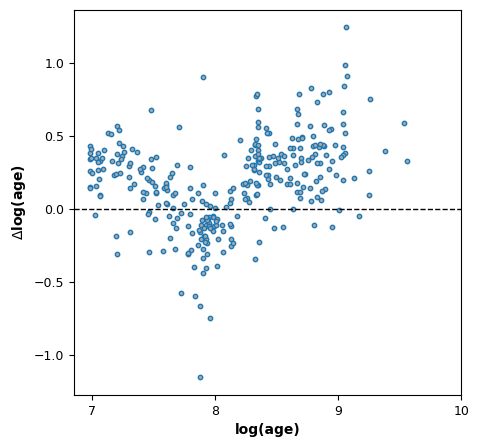

In [72]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(common_clusters['logAge_our'], common_clusters['logAge_our'] - common_clusters['logAge_hunt'], marker='o', s=10, \
           color="darkgrey", ec="C0", lw=1.0)
ax.axhline(0, ls='--', lw=1., color='k')
ax.set_xticks([7,8,9,10])
ax.set_xlabel("log(age)", fontsize=10, weight='bold')
ax.set_ylabel("$\Delta$log(age)", fontsize=10, weight='bold')
ax.tick_params(axis='both', labelsize=9)
ax.set_aspect('auto', adjustable='box')

In [32]:
open_cluster = df[df['Cluster']=='FSR_0551']
open_cluster

,Cluster,GaiaDR3,RA_ICRS,DE_ICRS,pmRA,pmDE,Plx,PlxCorr,_RA.icrs,_DE.icrs,d
18179,FSR_0551,519062263906703616,25.720121,65.280251,0.145523,-1.496366,1.067566,1.035993,25.720120,65.280258,936.710660
18180,FSR_0551,513105212990840704,25.361267,65.311283,-0.422009,-1.303010,1.048930,1.013257,25.361272,65.311289,953.352813
18181,FSR_0551,513111500823058560,24.654965,65.187287,-1.064354,-1.387709,1.081498,1.050597,24.654976,65.187293,924.643539
18182,FSR_0551,513116895301688704,24.277254,65.311697,-0.229565,-1.651650,1.059241,1.026535,24.277256,65.311705,944.072507
18183,FSR_0551,513117445057496192,24.302683,65.356300,0.289756,-1.394796,1.036253,1.004739,24.302680,65.356306,965.015393
...,...,...,...,...,...,...,...,...,...,...,...
18358,FSR_0551,512944031457254144,23.352079,64.348435,0.243551,-1.589755,1.079553,1.047674,23.352077,64.348442,926.309232
18359,FSR_0551,513171080606619648,23.262696,64.820356,-0.133922,-1.528152,1.027586,0.995551,23.262697,64.820363,973.154350
18360,FSR_0551,512982033328572672,24.127515,64.736298,-0.957688,-2.063772,1.075505,1.043573,24.127525,64.736307,929.796045
18361,FSR_0551,513210285068834688,22.409533,64.886530,-0.092947,-1.431257,1.025125,0.994247,22.409534,64.886537,975.490543


184


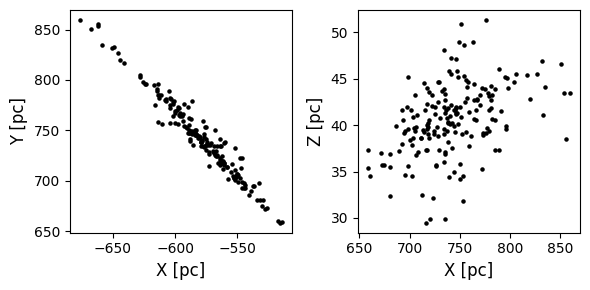

In [42]:
open_cluster = df[df['Cluster']=='FSR_0551']
print(len(open_cluster))

c = apycoords.SkyCoord(ra=open_cluster['RA_ICRS'].values*u.deg, dec=open_cluster['DE_ICRS'].values*u.deg, \
                       distance=open_cluster['d'].values *u.pc, frame='icrs')

fig, ax = plt.subplots(1,2, figsize=(6,3))

ax[0].scatter(c.galactic.cartesian.x, c.galactic.cartesian.y, s=5, marker='o', color='k')
ax[0].set_xlabel('X [pc]', fontsize=12)
ax[0].set_ylabel('Y [pc]', fontsize=12)

ax[1].scatter(c.galactic.cartesian.y, c.galactic.cartesian.z, s=5, marker='o', color='k')
ax[1].set_xlabel('X [pc]', fontsize=12)
ax[1].set_ylabel('Z [pc]', fontsize=12)

plt.tight_layout()
plt.show()

939.3254563546716


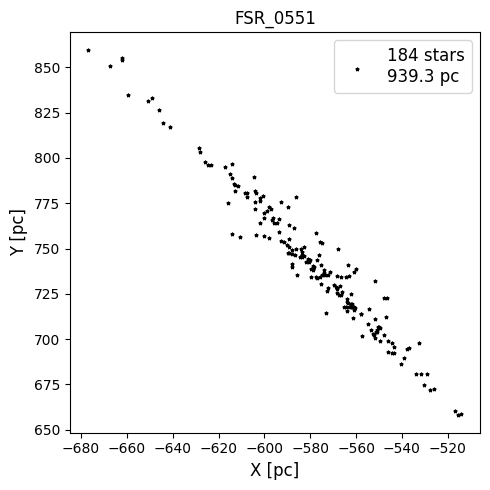

In [55]:
fig, ax = plt.subplots(figsize=(5,5))
print(np.median(open_cluster['d']))
ax.set_title('FSR_0551')
ax.scatter(c.galactic.cartesian.x, c.galactic.cartesian.y, s=5, marker='*', color='k', \
           label='{} stars\n{:.1f} pc'.format(len(open_cluster),np.median(open_cluster['d'])))
ax.set_xlabel('X [pc]', fontsize=12)
ax.set_ylabel('Y [pc]', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Alfonso paper 1 members

In [75]:
catalog = 'J/A+A/677/A163/members'
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
alfonso_2023 = query.to_pandas()
#df = df.rename(columns={'Cluster':'cluster'})
#our = df.fillna(0)
#our = our[['cluster','logAge']]
alfonso_2023

,GaiaDR3,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Cluster,_RA.icrs,_DE.icrs
0,63449521800719488,55.773982,21.030220,7.661184,19.368667,-46.283156,Pleiades,55.773890,21.030425
1,63502259702709888,56.383383,21.246480,7.748071,20.652807,-47.762058,Pleiades,56.383284,21.246693
2,63507860340462208,56.593062,21.088765,7.589614,20.472016,-46.552291,Pleiades,56.592964,21.088972
3,63527827643105408,56.532550,21.345159,7.234548,19.009062,-45.063595,Pleiades,56.532459,21.345359
4,65588484235454592,58.268967,22.801153,7.293433,19.036700,-45.560948,Pleiades,58.268875,22.801355
...,...,...,...,...,...,...,...,...,...
2185,2334037755821523968,359.253456,-27.923260,4.321179,18.987411,1.910564,Blanco_1,359.253361,-27.923269
2186,2334138636012819328,359.363457,-27.693084,4.125127,18.486758,2.119758,Blanco_1,359.363364,-27.693094
2187,2334148870920034432,359.136106,-27.759816,4.270982,19.070604,1.931769,Blanco_1,359.136011,-27.759825
2188,2334177599956226688,359.945951,-27.328056,4.239831,18.613021,1.761267,Blanco_1,359.945858,-27.328064


In [89]:
catalog = 'J/A+A/689/A18/clusters'
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
alfonso_2024 = query.to_pandas()
alfonso_2024 = alfonso_2024[alfonso_2024['Cluster'].isin(['Melotte_22','NGC_2632','Blanco_1'])]
alfonso_2024 = alfonso_2024[['Cluster','Nstars']]
#df = df.rename(columns={'Cluster':'cluster'})
#our = df.fillna(0)
#our = our[['cluster','logAge']]
alfonso_2024

,Cluster,Nstars
56,Blanco_1,579
110,Melotte_22,1130
143,NGC_2632,862


# Cantag-Gaudin members

In [90]:
catalog = 'J/A+A/640/A1/table1' #Portrait Galactic disc cantat-gaudin-2020
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
cg_2020 = query.to_pandas()

cg_2020 = cg_2020.rename(columns={'Cluster':'cluster','RA_ICRS': 'ra','DE_ICRS': 'dec', 'pmRA_':'pmra','pmDE':'pmdec',\
                        'plx':'parallax','nbstars07':'n_stars','AgeNN':'logAge','AVNN':'av','DMNN':'m_M'})
cg_2020 = cg_2020[(cg_2020.Flag != 'notEnoughStars') & (cg_2020.Flag != 'tooRed')].reset_index(drop=True) 
cg_2020 = cg_2020[['cluster','ra','dec','pmra','pmdec','n_stars','parallax','logAge','av','m_M']]
cg_2020 = cg_2020.loc[~cg_2020['cluster'].isin(['Melotte_25','Melotte_111'])] # remove hyades and coma clusters
cg_2020 = cg_2020[cg_2020['cluster'].isin(['Melotte_22','NGC_2632','Blanco_1'])]
cg_2020 = cg_2020[['cluster','n_stars']]
cg_2020

,cluster,n_stars
201,Blanco_1,380
666,Melotte_22,952
802,NGC_2632,685


# Hunt

In [93]:
catalog = 'J/A+A/673/A114/clusters' 
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
hunt_2023 = query.to_pandas()
hunt_2023 = hunt_2023[hunt_2023['Name'].isin(['Melotte_22','NGC_2632','Blanco_1'])]
hunt_2023 = hunt_2023[['Name','N']]
hunt_2023

,Name,N
281,Blanco_1,841
4423,Melotte_22,1721
4598,NGC_2632,1314


In [94]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl

In [ ]:
vegetables = ["AF2023", "CG2020", "AF2024", "Hunt2023"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])